# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

The purpose of this project is to find lane lines on the road from images and video streams.

First, 

---
In addition, 


---

## Set up packages to use

In [139]:
#import libraries to be used and set up for a plot inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


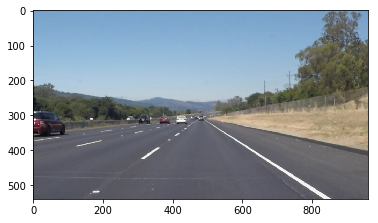

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper functions step by step

In [54]:
def detect_edges(img):
    #1. to gray colour
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    #2. experiment a kernel size and image smooothing through Gaussian Blur to remove noise
    #https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html
    #if sigmaX is non-positive, it is calculated from a kelnel size: sigma = 0.3\*((kernel_size-1)\*0.5 - 1) + 0.8
    kernel_size = 5
    gblur_img = cv2.GaussianBlur(gray_img,(kernel_size, kernel_size), sigmaX=0)
    
    #3. experiment various thresholds (min and max) to get sound canny edges
    min_threshold = 50
    max_threshold = 150
    canny_edges = cv2.Canny(gblur_img, min_threshold, max_threshold)
    
    return canny_edges

In [131]:
def confine_roi(edges):
    #1. create mask background from the size of an image and make all pixels black (i.e. rgb 0)
    mask_background = np.zeros_like(edges)
    
    #2. get the size of an image and define vertices of region of interest - ellipse2Poly()
    img_shape = image.shape
    vertices = np.array([[(0,img_shape[0]),(img_shape[1]//2, img_shape[0]//2), (img_shape[1],img_shape[0])]], dtype=np.int32)
    
    #3. areas that are not masked (i.e. region of interest) are coloured white (255)
    #where there are more than 1 channel (e.g. RGB)
    if len(img_shape) > 2:
        channel_count = img_shape[2]
        not_mask_color = (255,) * channel_count
    else:
        not_mask_color = 255
    
    #4. cv2.fillPoly() fills an area bounded by several polygonal outlines with 1
    cv2.fillPoly(mask_background, vertices, not_mask_color)
    
    #5. bitwise_and finds an area where both pixel values are 1
    masked_edges = cv2.bitwise_and(edges, mask_background)
    
    return masked_edges

In [132]:
def connect_edges(edges):
    #1. define parameters for hough transform: rho, theta
    #distance
    rho = 2
    #angle
    theta = np.pi/180
    #minimum number of votes
    threshold = 150
    #minimum number of pixels making up a line
    min_line_length = 100
    #maximum gap in pixels between connectable line segments
    max_line_gap = 100
    
    #2. connect dots and edges through hough line transform
    hough_lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    
    return hough_lines

In [133]:
def extrapolate_lines(img, lines):
    #1. initialise empty arrays for left lane and right lane Xs and Ys
    left_lanes = []
    right_lanes = []
    
    #2. for all lines found by hough transformation, get slopes and intercepts
    for line in lines:
        x1, y1, x2, y2 = np.squeeze(line)
        #fit each line between two points (i.e. x1, y1 and x2, y2)
        p_slope, p_int = np.polyfit((x1, x2), (y1, y2), 1)
        #if the slope is forward slash, then takes it into left; otherwise right
        if p_slope > 0:
            left_lanes.append((p_slope, p_int))
        else:
            right_lanes.append((p_slope, p_int))
        
    #3. get median of collections of slopes and intercepts to determine a single representative lane for each
    left_lanes_median = np.median(left_lanes, axis=0)
    right_lanes_median = np.median(right_lanes, axis=0)
        
    return [left_lanes_median, right_lanes_median]

In [134]:
def get_xys(img_shape, lanes):
    left_lanes = lanes[0]
    right_lanes = lanes[1]
    
    first_slope, first_int = left_lanes
    second_slope, second_int = right_lanes
    
    #3. get left lane xys through first slope and intercept
    margin = 250
    left_y1 = img_shape[0]
    left_y2 = int(left_y1 - margin)
    left_x1 = int((left_y1 - first_int)/first_slope)
    left_x2 = int((left_y2 - first_int)/first_slope)
    
    #4. get left lane xys through second slope and intercept
    right_y1 = img_shape[0]
    right_y2 = int(right_y1 - margin)
    right_x1 = int((right_y1 - second_int)/second_slope)
    right_x2 = int((right_y2 - second_int)/second_slope)
    
    return [[left_x1, left_y1, left_x2, left_y2], [right_x1, right_y1, right_x2, right_y2]]

In [135]:
def connect_lines(img, left_right_xys):
    #copy an image with zero initiations to draw lines on
    image_with_lines = np.zeros_like(img)
    #going through each xys and draw a line between them for left and right lanes
    if xys is not None:
        for i in range(len(left_right_xys)):
            x1, y1, x2, y2 = xys[i]
            cv2.line(image_with_lines, (x1, y1), (x2, y2), (178, 0, 255), 5)
    return image_with_lines

Wrapper function for all steps

In [136]:
def find_lanes(path2image):
    #reading in an image with cv2 instead of mpimg
    image = cv2.imread(path2image)

    #need to change BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
       
    detected_edges = detect_edges(image)
    masked_edges = confine_roi(detected_edges)
    hough_lines = connect_edges(masked_edges)
    median_lanes = extrapolate_lines(image, hough_lines)
    xys = get_xys(image.shape, median_lanes)
    connected_lines = connect_lines(image, xys)
    #addWeighted src1, src1 weight, src2, src2 weight, bias
    output_lines = cv2.addWeighted(image, 0.95, connected_lines, 5., 0.)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    fig.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(output_lines)
    ax2.set_title('Sample Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

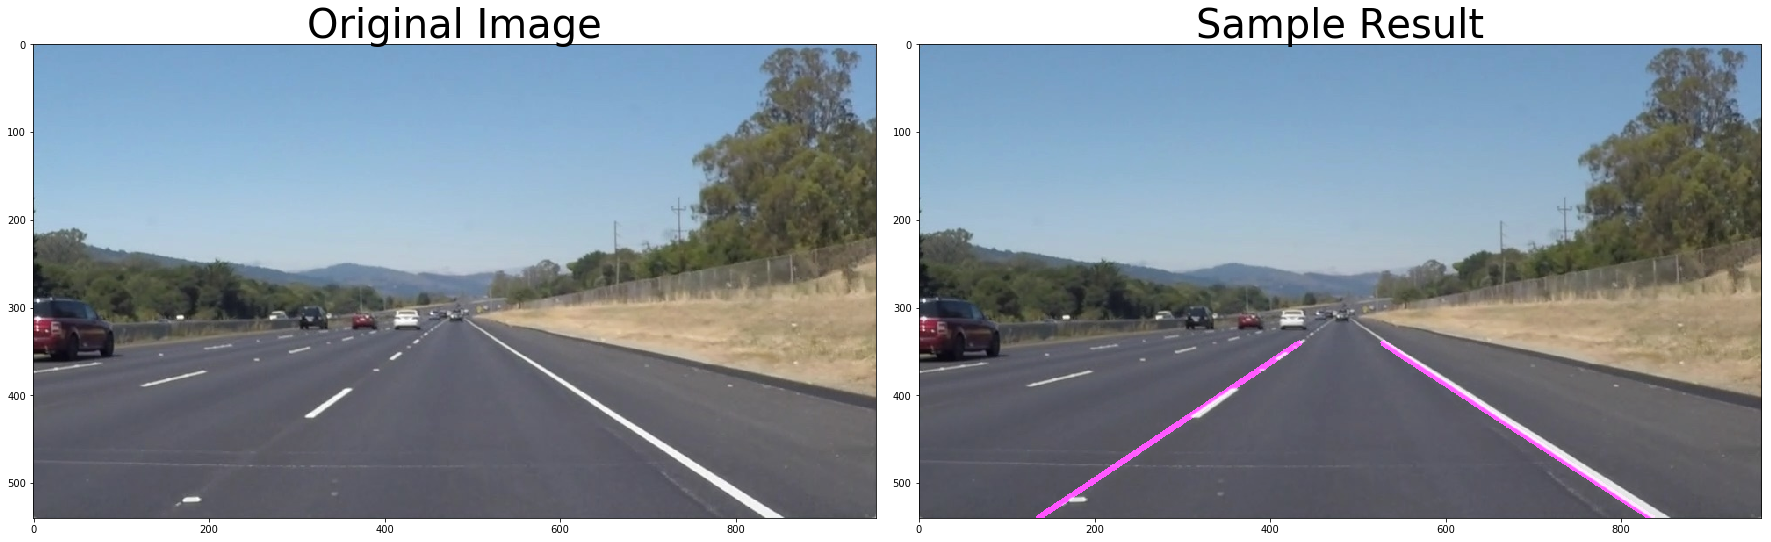

In [137]:
find_lanes('test_images/solidWhiteRight.jpg')

The lines seems to be reasonable on a sample image. Now I am ready to try on test images.

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [146]:
def find_lanes_on_test(testdir):
    for img in os.listdir(testdir):
        #reading in an image with cv2 instead of mpimg
        image = cv2.imread(os.path.join(testdir, img))

        #need to change BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        detected_edges = detect_edges(image)
        masked_edges = confine_roi(detected_edges)
        hough_lines = connect_edges(masked_edges)
        median_lanes = extrapolate_lines(image, hough_lines)
        xys = get_xys(image.shape, median_lanes)
        connected_lines = connect_lines(image, xys)
        #addWeighted src1, src1 weight, src2, src2 weight, bias
        output_lines = cv2.addWeighted(image, 0.95, connected_lines, 5., 0.)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        fig.tight_layout()

        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=40)

        ax2.imshow(output_lines)
        ax2.set_title('Sample Result', fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

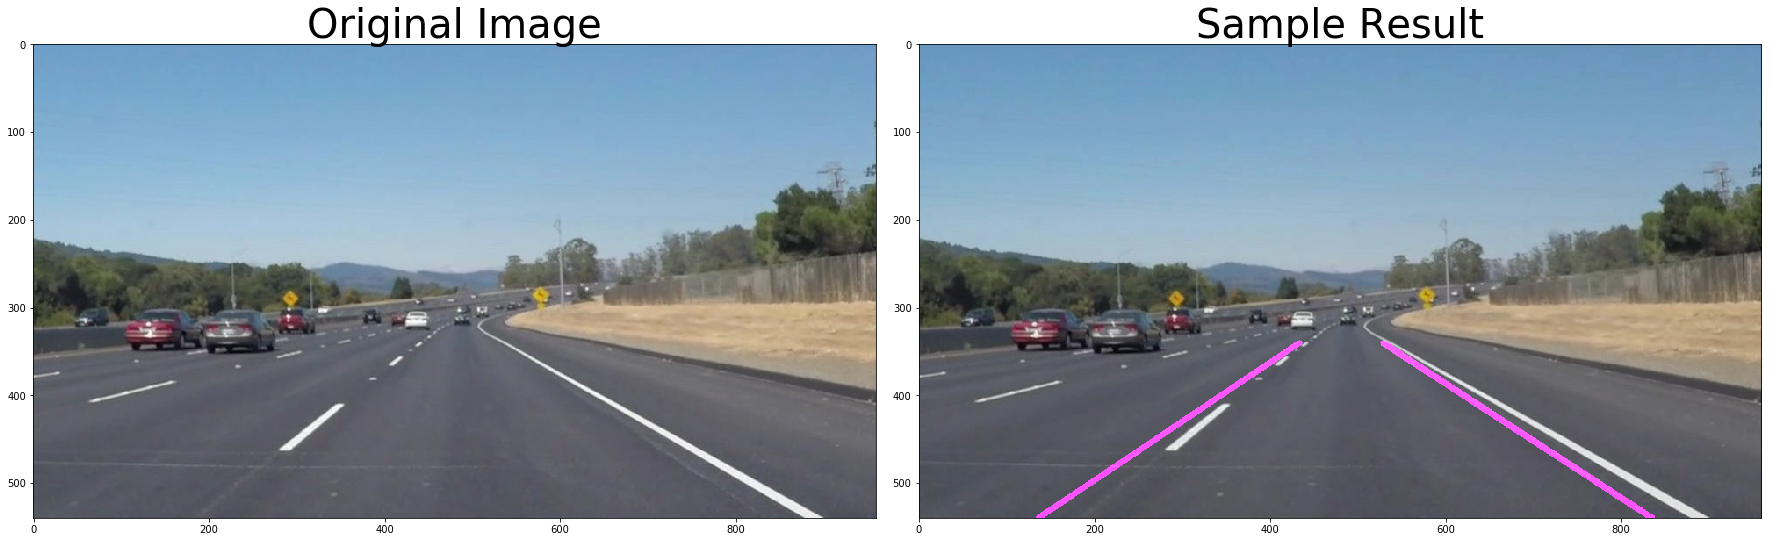

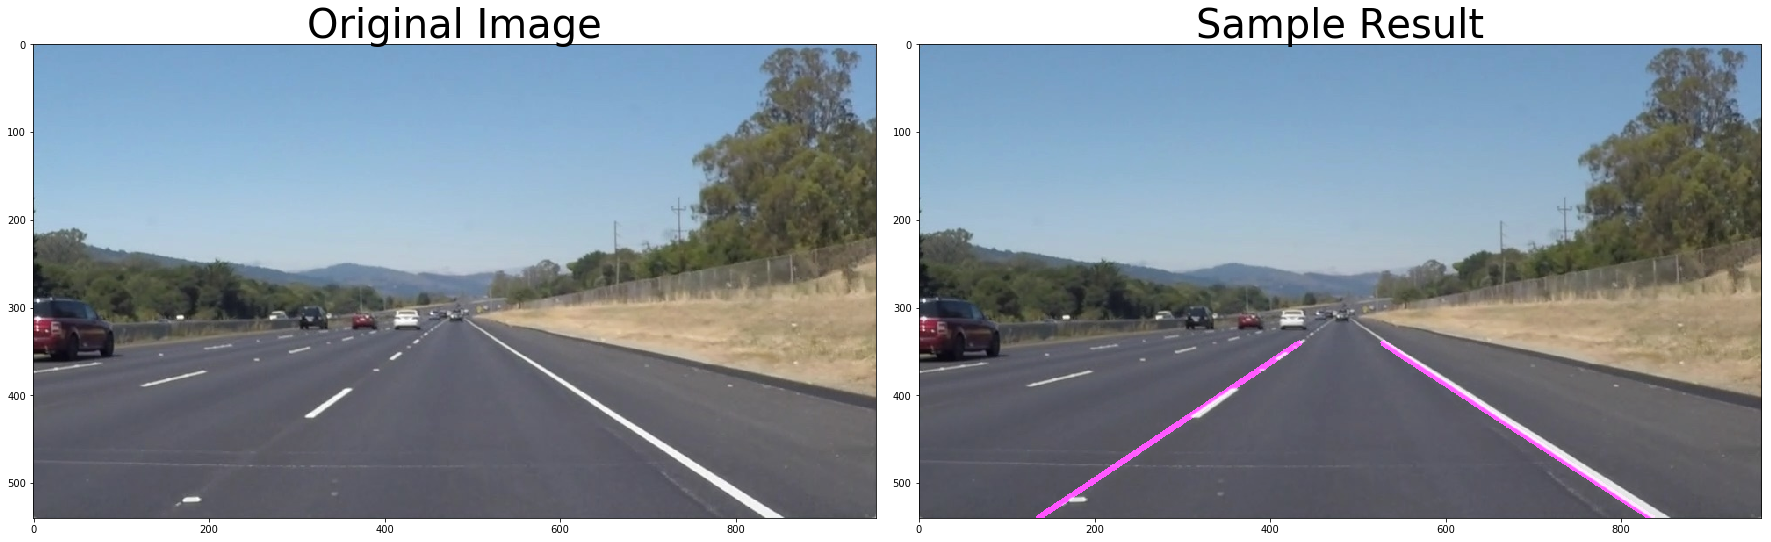

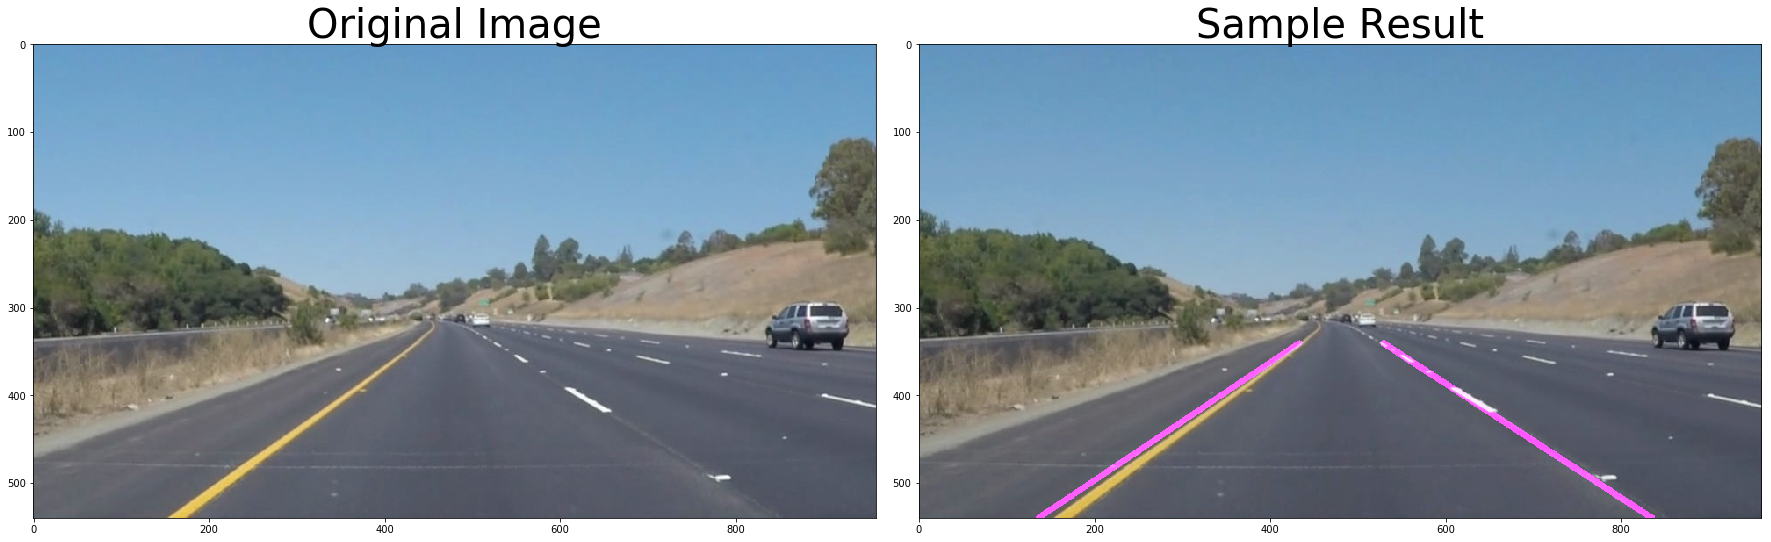

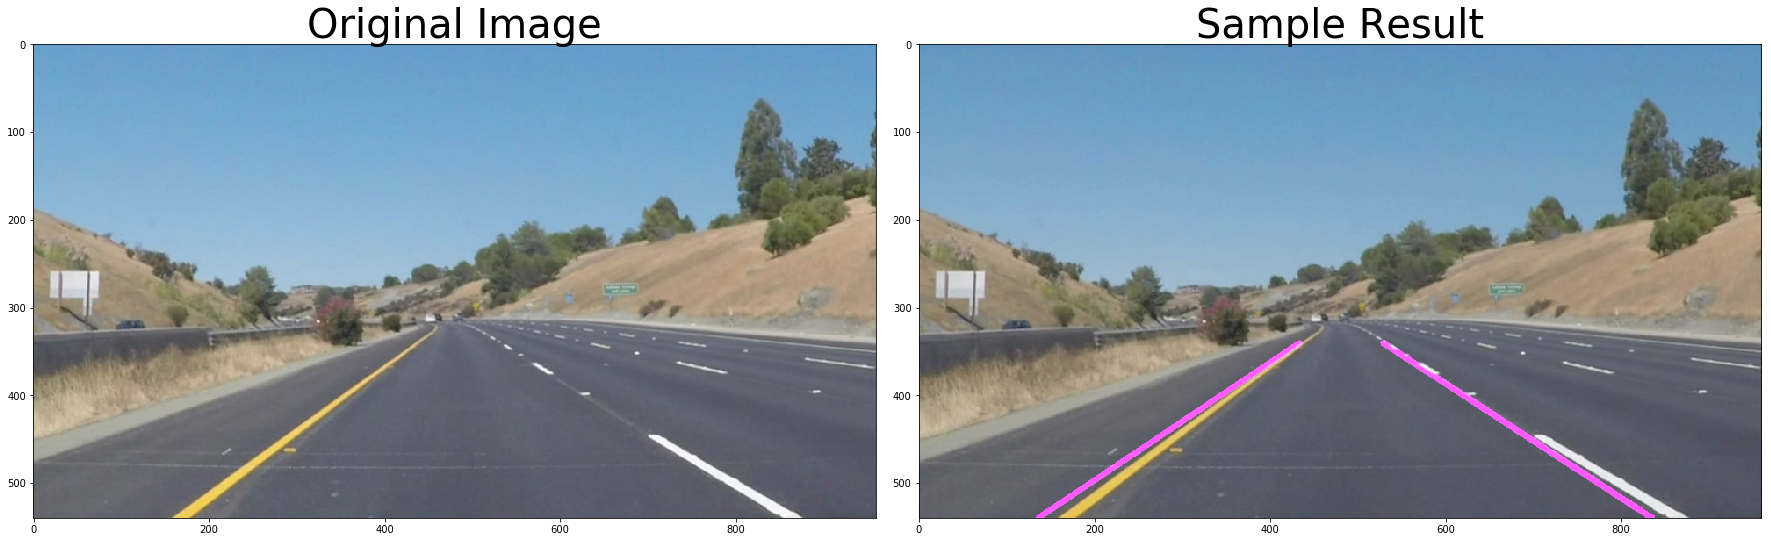

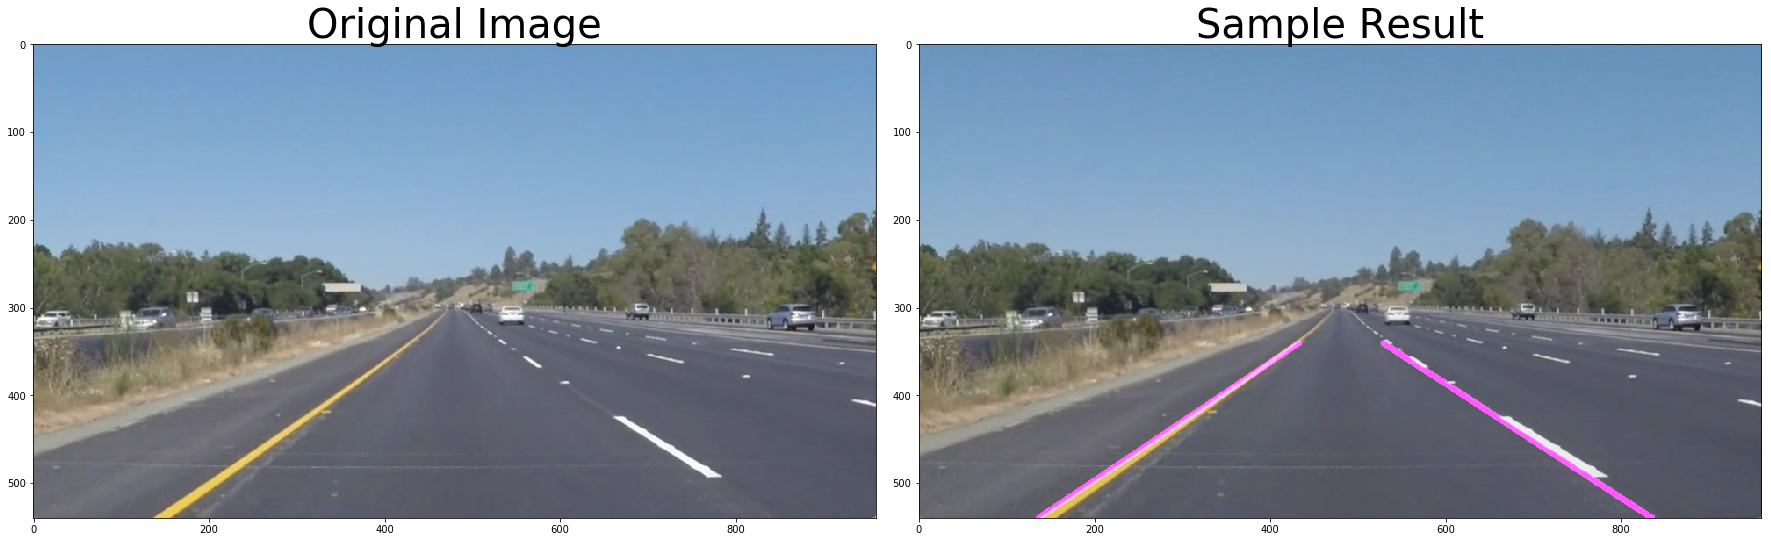

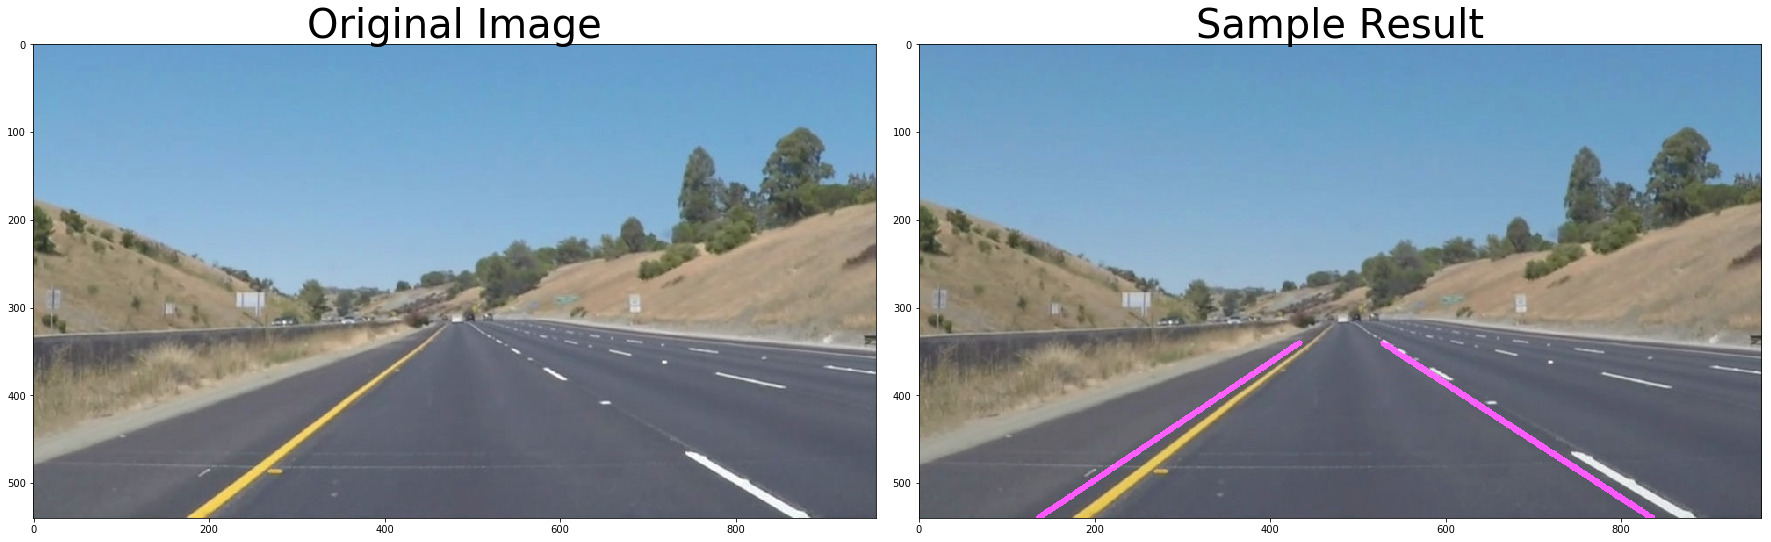

In [147]:
find_lanes_on_test("test_images/")

All images look reasonable and now I would like to test on a video stream. I will consider improving results in the later section. 